# GROUP REPORT: Classification of Hazardous/Nonhazardous Nearest Earth Objects (NEOs)

<p>Section: 008<br>
Group: 34<br>
Authors: Philip Chen, Liam Guetg, Vanesse Li, Ada Jiang</p>

### Introduction:
A near-earth object (NEO) is an asteroid or comet with an orbit that approaches a point within 1.3 astronomical units of the sun.<sup>[1](#1)</sup> The JPL Center for NEO Studies conducts research on these objects by computing orbits and assessing the impact risk (of collision) of individual NEOs over time.<sup>[3](#1)</sup>

In this project, we want to expand the JPL's research. To determine the impact risk of a NEO, we must predict its trajectory by studying observable attributes.<sup>[2](#1)</sup> However, NEOs are irregularly shaped and are constantly moving, so measurements are estimates are taken at various times, distances and phase angles.<sup>[3](#1)</sup> Considering this imperfect data, we want to create an effective binary classifier that uses the K-nearest neighbours algorithm to predict whether a given NEO is harmful or not based on various quantitative measurements. A NEO's hazardous designation changes based on updated trajectory predictions, so it is more important that our classifier correctly identify a hazardous NEO as hazardous (i.e., have high recall) than prevent false positives.<sup>[3](#1)</sup>. Our question is, which predictors and what K value will produce a classifier that predicts a NEO's hazardous designation with the highest accuracy and recall?

#### NEO Dataset
This dataset compiles the list of NASA certified asteroids that are classified as NEOs.<sup>[4](#1)</sup>

1. **id** (unique identifier for each asteroid)
2. **name** (name of asteroid given by NASA)
3. **est_diameter_min** (minimum estimated diameter in kilometres)
4. **est_diameter_max** (maximum estimated diameter in kilometres)
5. **relative_velocity** (velocity relative to earth)
6. **miss_distance** (distance in kilometres missed)
7. **orbiting_body** (planet that the asteroid orbits)
8. **sentry_object** (included in JPL Sentry System?)
9. **absolute_magnitude** (intrinsic mean brightness)<sup>[5](#1)</sup>
10. **hazardous** (boolean factor that indicates whether asteroid is harmful or not)

### Preliminary exploratory data analysis:

In [8]:
# Run this cell before continuing
install.packages("cowplot")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [10]:
# Run this cell before continuing
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(kknn)
library(shiny)

Rows: 90836 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, orbiting_body
dbl (6): id, est_diameter_min, est_diameter_max, relative_velocity, miss_dis...
lgl (2): sentry_object, hazardous

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<fct>
2162635,162635 (2000 SS164),1.19827080,2.67941497,13569.25,54839744,Earth,FALSE,16.73,FALSE
2277475,277475 (2005 WK4),0.26580000,0.59434687,73588.73,61438127,Earth,FALSE,20.00,TRUE
2512244,512244 (2015 YE18),0.72202956,1.61450717,114258.69,49798725,Earth,FALSE,17.83,FALSE
3596030,(2012 BV13),0.09650615,0.21579430,24764.30,25434973,Earth,FALSE,22.20,FALSE
3667127,(2014 GE35),0.25500869,0.57021676,42737.73,46275567,Earth,FALSE,20.09,TRUE
54138696,(2021 GY23),0.03635423,0.08129053,34297.59,40585691,Earth,FALSE,24.32,FALSE


Shiny tags cannot be represented in plain text (need html)

[1] "Number of observations that are missing data values:  0"


orbiting_body,count
<chr>,<int>
Earth,90836


Shiny tags cannot be represented in plain text (need html)

hazardous,count
<fct>,<int>
FALSE,81996
TRUE,8840


Shiny tags cannot be represented in plain text (need html)

est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2106759,0.4710856,55323.22,39574974,22.12517


Shiny tags cannot be represented in plain text (need html)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


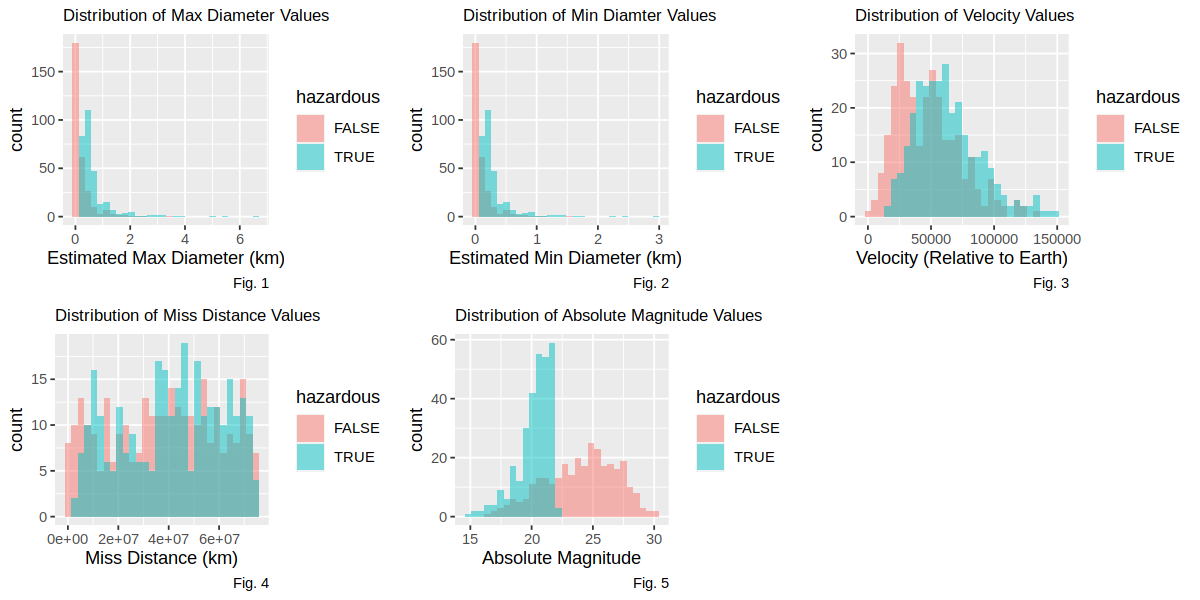

In [68]:
set.seed(1) #added a seed to make the results reproducible

options(repr.plot.width = 10, repr.plot.height = 5)
url <- "https://raw.githubusercontent.com/LongTortue/DSCI100-Group-Project/main/neo.csv"
neo_data <- read_csv(url)

neo_data <- neo_data |>
mutate(hazardous = as_factor(hazardous))
head(neo_data) # transforming the intended prediction variable into a categorical variable
h4("Table 1: Initial dataset")

neo_na_count <- sum(is.na(neo_data))
print(paste("Number of observations that are missing data values: ", neo_na_count)) # no missing values in our dataset

neo_count_orbiting <- neo_data |>
group_by(orbiting_body) |>
summarize(count = n())
neo_count_orbiting # all observations have orbiting bodies of Earth
h4("Table 2: Total number of observations and orbiting body")

neo_count_data <- neo_data|>
group_by(hazardous)|>
summarize(count = n())
neo_count_data
h4("Table 3: Count of observations in each class")

# as the data is unbalanced (81000 false to 9000 true), we will create a new dataset that is balanced,
# with limitations that will be expanded upon further on

neo_data_false <- neo_data |>
filter(hazardous == "FALSE") |>
sample_n(400)
neo_data_true <- neo_data |>
filter(hazardous == "TRUE") |>
sample_n(400)
neo_data_balanced <- rbind(neo_data_false, neo_data_true) # balanced dataset

neo_data_split <- initial_split(neo_data_balanced, prop = 0.75, strata = hazardous)
neo_data_train <- training(neo_data_split)
neo_data_test <- testing(neo_data_split)

#neo_count <- neo_data_train |>
#group_by(hazardous) |>
#summarize(count = n())
#neo_count # number of observations in each class
#h4("Table 3: Number of observations in each category (Hazardous vs Not hazardous)")



neo_mean <- neo_data_train |>
select(-id, -name, -orbiting_body, -sentry_object, -hazardous) |>
map_df(mean)
neo_mean # mean of predictors
h4("Table 4: Mean value of each variable")



# plots visualizing distribution of data, and shown next to each other
neo_plot_max_diameter_comparison <- neo_data_train |>
    ggplot(aes(x = est_diameter_max, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Estimated Max Diameter (km)") +
    ggtitle("Distribution of Max Diameter Values") +
    labs(caption = "Fig. 1") +
    theme(plot.title = element_text(size = 10))

neo_plot_min_diameter_comparison <- neo_data_train |>
    ggplot(aes(x = est_diameter_min, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Estimated Min Diameter (km)") +
    ggtitle("Distribution of Min Diamter Values") +
    labs(caption = "Fig. 2") +
    theme(plot.title = element_text(size = 10))

neo_plot_velocity_comparison <- neo_data_train |>
    ggplot(aes(x = relative_velocity, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Velocity (Relative to Earth)") +
    ggtitle("Distribution of Velocity Values") +
    labs(caption = "Fig. 3") +
    theme(plot.title = element_text(size = 10))
neo_plot_miss_distance_comparison <- neo_data_train |>
    ggplot(aes(x = miss_distance, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Miss Distance (km)") +
    ggtitle("Distribution of Miss Distance Values") +
    labs(caption = "Fig. 4") +
    theme(plot.title = element_text(size = 10))

neo_plot_abs_magnitude_comparison <- neo_data_train |>
    ggplot(aes(x = absolute_magnitude, fill = hazardous)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    xlab("Absolute Magnitude") +
    ggtitle("Distribution of Absolute Magnitude Values") +
    labs(caption = "Fig. 5") +
    theme(plot.title = element_text(size = 10))

plot_grid(neo_plot_max_diameter_comparison, neo_plot_min_diameter_comparison, neo_plot_velocity_comparison, 
          neo_plot_miss_distance_comparison, neo_plot_abs_magnitude_comparison)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7933333,5,0.014766704,Preprocessor1_Model01
2,roc_auc,binary,0.8413889,5,0.013009300,Preprocessor1_Model01
3,accuracy,binary,0.7883333,5,0.016372402,Preprocessor1_Model02
3,roc_auc,binary,0.8530278,5,0.009286714,Preprocessor1_Model02
4,accuracy,binary,0.7883333,5,0.016372402,Preprocessor1_Model03
4,roc_auc,binary,0.8542778,5,0.007341615,Preprocessor1_Model03


Shiny tags cannot be represented in plain text (need html)

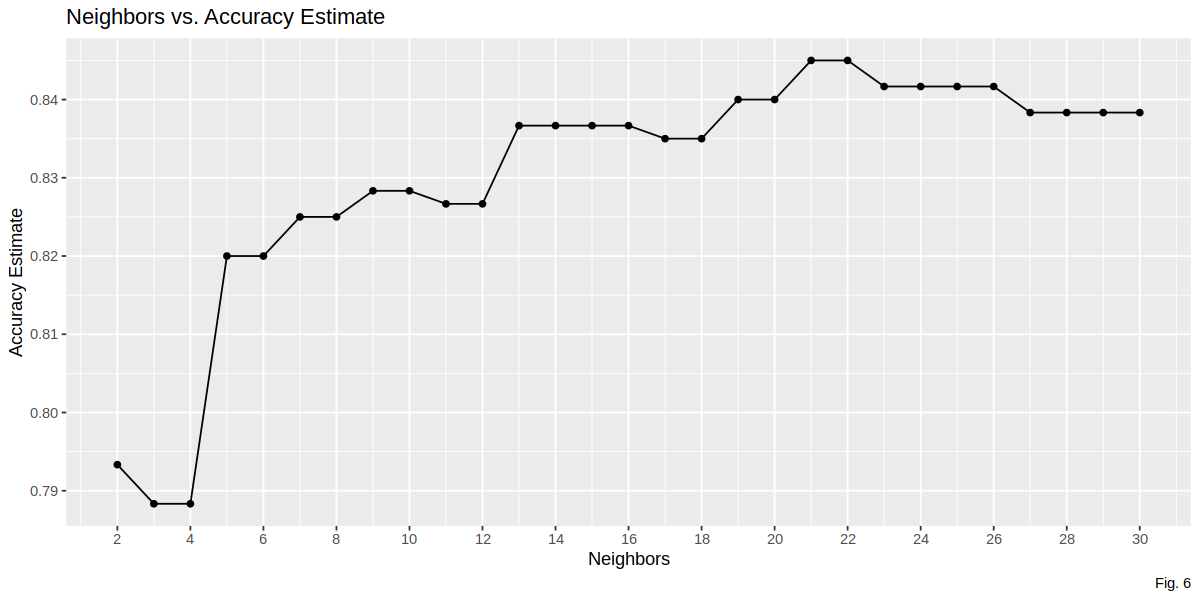

In [67]:
# TO DO
set.seed(50)
# Create standaridization recipe
neo_recipe <- recipe(hazardous ~ est_diameter_min + est_diameter_max + 
                     relative_velocity + miss_distance + absolute_magnitude, data = neo_data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create a nearest_neighbors model specification
neo_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Cross validation, vfold thing
neo_vfold <- vfold_cv(neo_data_train, v = 5, strata = hazardous)

# Combine the recipe and model in workflow, train and tune classifier
k_vals <- tibble(neighbors = seq(2, 30))

knn_results <- workflow() |>
    add_recipe(neo_recipe) |>
    add_model(neo_model) |>
    tune_grid(resamples = neo_vfold, grid = k_vals) |>
    collect_metrics()
head(knn_results)
h4("Table 5: Collected metrics")

# graph results
accuracies <- knn_results |>
    filter(.metric == "accuracy")

results_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Neighbors vs. Accuracy Estimate") +
    labs(caption = "Fig. 6") +
    scale_x_continuous(breaks = seq(0, 30, by = 2))
results_plot

#highest_accuracy_k <- slice_max(accuracies, mean, n = 1)
#highest_accuracy_k
#h4("Table 6")



# NOTE: We have to decide how many K values to use to tune the classifier with
# Make a new model specification using the K value that yields high accuracy and recall values
# Visualize data analysis results (make plots for accuracy and recall values)
# Evaluate dataset (use test dataset)
# Maybe at the end, we can test the classifier with a random observation that we make up

# Note: all tables and figure should have a figure/table number and a legend
# Word count: max 2000 written words, not including citations

# Along the way, add details to the "Methods" section
# Complete the Discussion by summarize the conclusions we made from data analysis
# If we haven't maxed out the 2000 word count, add more to "Intro", "NEO Dataset", 
#                                              and "Expected outcomes and Significance"

# Note: For references, any reputable source is fine

In [75]:
set.seed(50)

neo_model_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 22) |>
    set_engine("kknn") |>
    set_mode("classification")

neo_fit <- workflow() |>
    add_recipe(neo_recipe) |>
    add_model(neo_model_best) |>
    fit(data = neo_data_train)

neo_predictions <- predict(neo_fit, neo_data_test) |>
    bind_cols(neo_data_test)

neo_metrics <- neo_predictions |>
    metrics(truth = hazardous, estimate = .pred_class)
slice(neo_metrics, 1)
h4("Table 6: Accuracy of classifier")

neo_conf_mat <- neo_predictions |>
    conf_mat(truth = hazardous, estimate = .pred_class)
neo_conf_mat
h4("Fig. 7: Confusion matrix")

precision_k_22 = format(round(75/(75 + 2), 4), nsmall=4)

recall_k_22 = 75/(75 + 25)

print(c("Precision", precision_k_22))
print(c("Recall", recall_k_22))


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.865


Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction FALSE TRUE
     FALSE    75    2
     TRUE     25   98

Shiny tags cannot be represented in plain text (need html)

[1] "Precision" "0.9740"   
[1] "Recall" "0.75"  


### Methods & Results:

To begin with the project, we install the packages and libraries necessary to perform the analysis.

We read the data through the database on the URL (Table 1) and convert hazardous into a categorical variable.

is.na() is used to check for missing values in the data set - of which there are none.

Grouping by orbiting body and counting the observations, we ensure all observations have an orbiting body of Earth (Table 2), as we are not concerned with the well being of other planets. :)

Grouping by hazardous and counting the number of observations in each class, we notice severe imbalance (Table 3). To work around this, we oversample the True class, generating a new balanced dataframe with 400 observations of each hazardous class randomly selected from the original dataset. A seed is set for this process to ensure reproducibility.

We then split the balanced data frame into a training set and a testing set with a 75% 25% split.  

To get a better grasp of the data we are dealing with, the mean value of each variable is calculated on the training set (Table 4).

Distribution graphs of each variable are also plotted as a histogram and coloured according to its hazardous class. Due to the varying distribution and huge difference in scale, step_scale and step_center are required (Figures 1-5).

A standardization recipe is created using the training data set. The JPL Sentry System (a reliable automated collision monitory system) uses these variables to calculate impact risk and predicted threat: 
1. est_diameter_min
2. est_diameter_max
3. relative_velocity
4. miss_distance
5. absolute_magnitude

As such, we will be using these variables as predictors in our classifier.

A recipe is created that uses the aforementioned variables as predictors to predict hazardous, as well as center and scale the predictors.

In order to determine the best k value, a nearest neighbour model and a 5-fold cross-validation set is created and tuned using k values from 2-30. A workflow is then created to yield a table with k values and their corresponding accuracy (Table 6).

We then plot a graph of k values versus the accuracy estimate created by cross-validation to determine the best k value (Fig. 6). 

Based on the plot, we can see that k = 21 and 22 have equal accuracies. We choose to use k = 22 over k = 21 as the variation in accuracy from k = 22 to 23 is lower compared to that of k = 21 to 20.

Using the proposed best k value of 22, a new nearest neighbour model is created. The training set is then fit into a new workflow using the new model and the same recipe previously used.

The classifier is then tested using the testing set. We then bind the column of the predicted hazard class to the testing set.

We then calculate the accuracy level using the metrics function, comparing between .pred_class (prediction) and hazardous (truth)(Table 6).

A confusion matrix is generated to calculate the precision and recall of our algorithm to assess its performance (Fig.7). 

We use format() to round to 4 decimal places, and then display the calculated precision and recall values.


### Discussion:


We set out to identify which predictors and what K value will produce a classifier that predicts a NEO's hazardous designation with the highest accuracy and recall. In our preliminary data analysis, we plotted each potential predictor on separate histograms to visualize the distribution of hazardous and non-hazardous NEO’s for each individual predictor (Fig. 1-5). Our results showed that the only predictor with significant overlap was miss distance (Fig. 4). While the other predictors didn’t show significant overlap, indicating their potential as valid predictors to determine if an unknown NEO is either hazardous (true) or not hazardous (false). Hence our findings indicated that the best predictors to use for this classification analysis are the NEO’s minimum estimated diameter (km), maximum estimated diameter (km), velocity relative to earth and its intrinsic brightness (absolute magnitude).  This was not an expected finding since the JPL Sentry System, a reliable predictor for hazardous NEO’s, uses miss distance as a predictor <sup>[5](#1)</sup>.

As per the methods, we then used these predictors to create a binary classification algorithm in order to predict whether an NEO is hazardous or not. Accounting for the differences in scale, mean values and imbalance we standardized the predictors and ensured the class was balanced. We then used cross-validation and determined that the best K-value to use. Our analysis showed that the highest accuracy was obtained by the K-values 21 and 22 (Fig. 6). We concluded that 22 was the best k-value to use as there was less variation in accuracy from k = 22 to 23 compared to that of k = 21 to 20 (Fig. 6). With this we were able to generate a model with the highest accuracy of 86.5% (Table 6). This is a relatively high accuracy indicating that our model is a capable algorithm with the ability to distinguish between hazardous and non-hazardous NEO’s.

Through further analysis we determined that our model had a recall value of 98% and a precision value of 79.7%. Recall indicates the percentage of hazardous NEO’s that were successfully predicted to be hazardous while the precision value indicates the percentage how many of the predicated hazardous NEO’s were actually hazardous. Since both values are relatively high, our model proves to be capable in differentiating between hazardous and non-hazardous NEO’s. Furthermore, since the recall is higher than the precision, our model appears to be more likely to indicate a false positive than a false negative. This is an acceptable trade-off because of the nature of what we are predicting: NEO’s can have devastating and potentially fatal consequences if one where to strike earth and hence it is better to have more false positives than to have false negatives which could potentially hit earth if not identified. 

These findings will have an impact on everyone's safety on Earth. With a reliable classification model, as demonstrated by our accuracy, precision, and recall, we can determine whether a NEO poses a significant risk to the planet before any collision occurs. Being able to classify an object's hazardousness through observable attributes allows us to be ready ahead of time and minimize potential damage. To improve our model, further analysis can focus on different combinations of predictors, or new predictors, that may improve the accuracy of our model.  Additionally, researchers may want to investigate ways to redirect the trajectory of an Earth-bound object and analyze alternative protective measures to minimize potential harm <sup>[7](#1)</sup>.

<a id="1"></a> 
### References
1. *Keeping an eye on Space Rocks.* (n.d.) NASA/JPL Caltech. https://www.jpl.nasa.gov/keeping-an-eye-on-space-rocks
2. *NEO Basics.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/about/target_earth.html
3. *Impact Risk.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/risk/intro.html
4. Vani, Sameep. *NASA - Nearest Earth Objects.* (n.d.) Kaggle. Retrieved October 26, 2023, from https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects
5. *Discovery Statistics.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/stats/
6. *Sentry: Earth Impact Monitoring.* (n.d.) NASA/JPL CNEOS. https://cneos.jpl.nasa.gov/sentry/
7. Tedesco, Edward. *Earth impact hazard.* (n.d.) Britannica. https://www.britannica.com/science/Earth-impact-hazard/Determining-the-hazard-potential-of-an-NEO